In [ ]:
import pandas as pd
import requests
import json
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import calendar
import itertools
import warnings
drive.mount('/content/drive')

Mounted at /content/drive


## External Data

The read_in_data(year) function in this Google Colab cell reads and processes demographic data from a CSV file for a specified year. It filters the relevant columns containing population estimates, simplifies the column names, and cleans the data by handling missing values and converting percentage values into decimal format. Additionally, the function calculates the total adult population by aggregating age groups and drops unnecessary columns to focus on key demographic and socioeconomic indicators, such as total population, median age, and median income. It also cleans income-related data, handling special cases like missing values.

The final output is a cleaned and structured dataset, making it ready for analysis. The processed data includes key demographics like population by race, income, and education levels, which can be used for further demographic or socioeconomic studies.

In [ ]:
def read_in_data(year):
  demographics = pd.read_csv(f'/content/drive/My Drive/data/{year}.csv')
  columns_to_keep = ['Label (Grouping)'] + [col for col in demographics.columns if 'Total!!Estimate' in col]
  demographics = demographics[columns_to_keep]
  new_column_names = ['Label (Grouping)'] + [col.split('!!')[0].split(',')[0].upper().replace(" COUNTY", "") for col in demographics.columns[1:]]
  demographics.columns = new_column_names
  demographics = demographics.dropna()
  demographics = demographics.set_index('Label (Grouping)').T.reset_index().rename(columns={'index': 'county'})
  demographics.columns = demographics.columns.str.strip()

  new_column_names = {
      'county': 'county',
      'Total population': 'total_pop',
      'Under 5 years': 'under_5',
      '5 to 17 years': 'age_5_17',
      '18 to 24 years': 'age_18_24',
      '25 to 44 years': 'age_25_44',
      '45 to 54 years': 'age_45_54',
      '55 to 64 years': 'age_55_64',
      '65 to 74 years': 'age_65_74',
      '75 years and over': 'over_75',
      'Median age (years)': 'median_age',
      'Male': 'male',
      'Female': 'female',
      'One race': 'one_race',
      'White': 'white',
      'Black or African American': 'black_afam',
      'American Indian and Alaska Native': 'am_indian_alaskan',
      'Asian': 'asian',
      'Native Hawaiian and Other Pacific Islander': 'pacific_islander',
      'Some other race': 'other_race',
      'Two or more races': 'two_plus_races',
      'Hispanic or Latino origin (of any race)': 'hisp_latino',
      'White alone, not Hispanic or Latino': 'white_non_hisp',
      'Population 5 years and over': 'pop_5_plus',
      'Speak language other than English': 'non_eng_speaker',
      'Speak English  "very well"': 'speak_eng_very_well',
      'Speak English less than "very well"': 'speak_eng_less_well',
      'Population 15 years and over': 'pop_15_plus',
      'Never married': 'never_married',
      'Now married, except separated': 'married',
      'Divorced or separated': 'div_sep',
      'Widowed': 'widowed',
      'Population 25 years and over': 'pop_25_plus',
      'Less than high school graduate': 'less_hs',
      'High school graduate (includes equivalency)': 'hs_grad',
      'Some college or associate\'s degree': 'some_college_assoc',
      'Bachelor\'s degree': 'bachelors',
      'Graduate or professional degree': 'grad_prof_degree',
      '$1 to $9,999 or loss': 'income_1_9999',
      '$10,000 to $14,999': 'income_10000_14999',
      '$15,000 to $24,999': 'income_15000_24999',
      '$25,000 to $34,999': 'income_25000_34999',
      '$35,000 to $49,999': 'income_35000_49999',
      '$50,000 to $64,999': 'income_50000_64999',
      '$65,000 to $74,999': 'income_65000_74999',
      '$75,000 or more': 'income_75000_plus',
      'Median income (dollars)': 'median_income',
      'Population for whom poverty status is determined': 'pop_poverty_determined',
      'Below 100 percent of the poverty level': 'below_poverty',
      '100 to 149 percent of the poverty level': 'poverty_100_149',
      'At or above 150 percent of the poverty level': 'above_150_poverty',
      'Citizenship status': 'citizenship_status',
      'Place of birth': 'place_of_birth'
  }
  demographics = demographics.rename(columns={'Speak English "very well"': 'speak_eng_very_well'})
  demographics['year'] = year
  demographics.rename(columns=new_column_names, inplace=True)
  for col in demographics.loc[:, 'under_5':'over_75'].columns.tolist():
    demographics[col] = demographics[col].str.replace('%', '').astype(float) / 100
  demographics['adult_pop'] = demographics[['age_18_24', 'age_25_44', 'age_45_54', 'age_55_64', 'age_65_74', 'over_75']].sum(axis=1)
  age_columns = ['under_5', 'age_5_17', 'age_18_24', 'age_25_44', 'age_45_54', 'age_55_64', 'age_65_74', 'over_75']
  demographics = demographics.drop(columns=age_columns)
  demographics_drop = demographics.drop(columns=['place_of_birth', 'citizenship_status', 'pop_15_plus', 'pop_25_plus', 'pop_5_plus', 'grad_prof_degree',
                                                 'female', 'above_150_poverty', 'pop_poverty_determined', 'never_married', 'married', 'non_eng_speaker',
                                                 'speak_eng_very_well', 'speak_eng_less_well'])
  income_columns = [col for col in demographics_drop.columns if 'income' in col]
  income_columns_to_drop = [col for col in income_columns if col != 'median_income']
  demographics_drop = demographics_drop.drop(columns=income_columns_to_drop)
  columns_list = demographics_drop.loc[:, 'male':'bachelors'].columns.tolist()
  for col in columns_list:
    demographics_drop[col] = demographics_drop[col].str.replace('%', '').astype(float) / 100
  for col in ['below_poverty', 'poverty_100_149']:
    demographics_drop[col] = demographics_drop[col].str.replace('%', '').astype(float) / 100
  columns = ['total_pop', 'median_age', 'median_income']
  for col in columns:
    # Only in median income for 2015 some value = '(X)'
    demographics_drop[col] = demographics_drop[col].replace('(X)', '-1')
    demographics_drop[col] = demographics_drop[col].str.replace(',', '').astype(float)
  return demographics_drop

In [ ]:
pd.set_option('display.max_rows', 10)
dfs = []
for year in range(2012, 2023):
  demographics_year = read_in_data(year)
  dfs.append(demographics_year)

demographics_all = pd.concat(dfs, ignore_index=True)
rows_to_update = demographics_all[(demographics_all['median_income'] == -1) & (demographics_all['year'] == 2015)]
# Fixed -1 for median income in 2015, by taking average between 2014 and 2016 for the 40 missing county data
for index, row in rows_to_update.iterrows():
  county = row['county']

  median_income_2014 = demographics_all[(demographics_all['county'] == county) & (demographics_all['year'] == 2014)]['median_income']
  median_income_2016 = demographics_all[(demographics_all['county'] == county) & (demographics_all['year'] == 2016)]['median_income']
  if not median_income_2014.empty and not median_income_2016.empty:
      mean_median_income = (median_income_2014.iloc[0] + median_income_2016.iloc[0]) / 2
      demographics_all.loc[index, 'median_income'] = mean_median_income
demographics_all.to_csv('demographics_2012_2022.csv', index=False)

## Iowa Data

**Had to group straight in api to get all data**

A query is constructed in SQL-like syntax to retrieve the year, month, county, category name, and the total sales and liters of liquor sold. The data is filtered to include records only before 2023 (since only have pre 2023 data for demographics) and ensures that the county and category name fields are not null. The query groups the data by year, month, county, and category name, and sets a limit of 10 million records to grab all of the records since orginal limit was 1000.

After retrieving the data via an HTTP request to an API, the response is processed as JSON and normalized into a pandas DataFrame using pd.json_normalize(). Additional data cleaning is performed by converting the year, month, total sales, and total liters columns to appropriate data types (integers and floats) to ensure they are ready for analysis. The result is a cleaned dataset of Iowa liquor sales, which is structured by date, county, and sales category.

In [ ]:
query = """
https://data.iowa.gov/resource/m3tr-qhgy.json?$select=date_extract_y(date) as year,
date_extract_m(date) as month, county, category_name, sum(sale_dollars) as total_sales, sum(sale_liters) as total_liters
&$where=date < '2023-01-01' AND county IS NOT NULL AND category_name IS NOT NULL
&$group=year, month, county, category_name
&$limit=10000000
"""

response = requests.get(query)
iowa = response.json()
df_iowa = pd.json_normalize(iowa)

In [ ]:
df_iowa = pd.read_csv(f'/content/drive/My Drive/data/iowa_liquor_sales.csv')
df_iowa['year'] = df_iowa['year'].astype(int)
df_iowa['month'] = df_iowa['month'].astype(int)
df_iowa['total_sales'] = df_iowa['total_sales'].astype(float)
df_iowa['total_liters'] = df_iowa['total_liters'].astype(float)

In [ ]:
category_mapping = {
    'COCKTAILS/RTD': 'Cocktails',
    'TRIPLE SEC': 'Liqueurs',
    'AMERICAN ALCOHOL': 'Other',
    'BUTTERSCOTCH SCHNAPPS': 'Schnapps',
    'SPICED RUM': 'Rums',
    'TROPICAL FRUIT SCHNAPPS': 'Schnapps',
    'SPECIAL ORDER ITEMS': 'Other',
    'CREAM LIQUEURS': 'Liqueurs',
    'COFFEE LIQUEURS': 'Liqueurs',
    '100% AGAVE TEQUILA': 'Tequila',
    'AMERICAN SCHNAPPS': 'Schnapps',
    'TENNESSEE WHISKIES': 'Whiskeys',
    'SINGLE MALT SCOTCH': 'Scotch',
    'BLENDED WHISKIES': 'Whiskeys',
    'WHITE RUM': 'Rums',
    'IMPORTED CORDIALS & LIQUEURS': 'Liqueurs',
    'BOTTLED IN BOND BOURBON': 'Bourbon',
    'AMERICAN VODKAS': 'Vodka',
    'NEUTRAL GRAIN SPIRITS FLAVORED': 'Other',
    'IMPORTED VODKAS': 'Vodka',
    'STRAIGHT RYE WHISKIES': 'Whiskeys',
    'MISC. IMPORTED CORDIALS & LIQUEURS': 'Liqueurs',
    'GREEN CREME DE MENTHE': 'Liqueurs',
    'MEZCAL': 'Tequila',
    'MIXTO TEQUILA': 'Tequila',
    'SCOTCH WHISKIES': 'Scotch',
    'CANADIAN WHISKIES': 'Whiskeys',
    'AMERICAN BRANDIES': 'Brandies',
    'AMERICAN CORDIALS & LIQUEURS': 'Liqueurs',
    'IMPORTED DRY GINS': 'Gins',
    'AMERICAN DRY GINS': 'Gins',
    'DISTILLED SPIRITS SPECIALTY': 'Other',
    'NEUTRAL GRAIN SPIRITS': 'Other',
    'AMERICAN FLAVORED VODKA': 'Vodka',
    'STRAIGHT BOURBON WHISKIES': 'Bourbon',
    'AMERICAN DISTILLED SPIRITS SPECIALTY': 'Other',
    'CORN WHISKIES': 'Whiskeys',
    'FLAVORED RUM': 'Rums',
    'IRISH WHISKIES': 'Whiskeys',
    'IMPORTED SCHNAPPS': 'Schnapps',
    'AMERICAN COCKTAILS': 'Cocktails',
    'AGED DARK RUM': 'Rums',
    'GRAPE SCHNAPPS': 'Schnapps',
    'WHISKEY LIQUEUR': 'Liqueurs',
    'IMPORTED BRANDIES': 'Brandies',
    'TEMPORARY & SPECIALTY PACKAGES': 'Other',
    'SINGLE BARREL BOURBON WHISKIES': 'Bourbon',
    'SPEARMINT SCHNAPPS': 'Schnapps',
    'FLAVORED GINS': 'Gins',
    'WATERMELON SCHNAPPS': 'Schnapps',
    '100 PROOF VODKA': 'Vodka',
    'RASPBERRY SCHNAPPS': 'Schnapps',
    'IMPORTED GRAPE BRANDIES': 'Brandies',
    'MISCELLANEOUS BRANDIES': 'Brandies',
    'PEACH SCHNAPPS': 'Schnapps',
    'CINNAMON SCHNAPPS': 'Schnapps',
    'DARK CREME DE CACAO': 'Liqueurs',
    'ROOT BEER SCHNAPPS': 'Schnapps',
    'PEPPERMINT SCHNAPPS': 'Schnapps',
    'GOLD RUM': 'Rums',
    'FLAVORED GIN': 'Gins',
    'AMERICAN GRAPE BRANDIES': 'Brandies',
    'IMPORTED FLAVORED VODKA': 'Vodka',
    'IOWA DISTILLERIES': 'Other',
    'MISCELLANEOUS SCHNAPPS': 'Schnapps',
    'MISC. AMERICAN CORDIALS & LIQUEURS': 'Liqueurs',
    'TEQUILA': 'Tequila',
    'BLACKBERRY BRANDIES': 'Brandies',
    'WHITE CREME DE MENTHE': 'Liqueurs',
    'VODKA FLAVORED': 'Vodka',
    'VODKA 80 PROOF': 'Vodka',
    'OTHER PROOF VODKA': 'Vodka',
    'AMERICAN AMARETTO': 'Liqueurs',
    'IMPORTED DISTILLED SPIRITS SPECIALTY': 'Other',
    'CHERRY BRANDIES': 'Brandies',
    'AMERICAN SLOE GINS': 'Gins',
    'PUERTO RICO & VIRGIN ISLANDS RUM': 'Rums',
    'IMPORTED VODKA - MISC': 'Vodka',
    'JAMAICA RUM': 'Rums',
    'APRICOT BRANDIES': 'Brandies',
    'PEACH BRANDIES': 'Brandies',
    'HOLIDAY VAP': 'Other',
    'ROCK & RYE': 'Whiskeys',
    'BARBADOS RUM': 'Rums',
    'IMPORTED AMARETTO': 'Liqueurs',
    'STRAWBERRY SCHNAPPS': 'Schnapps',
    'APPLE SCHNAPPS': 'Schnapps',
    'DECANTERS & SPECIALTY PACKAGES': 'Other',
    'WHITE CREME DE CACAO': 'Liqueurs',
    'CREME DE ALMOND': 'Liqueurs',
    'ANISETTE': 'Liqueurs',
    'JAPANESE WHISKY': 'Whiskeys',
    'DELISTED ITEMS': 'Other',
    'LOW PROOF VODKA': 'Vodka',
    'IMPORTED GINS': 'Gins',
    'IOWA DISTILLERY WHISKIES': 'Whiskeys',
    'IMPORTED WHISKIES': 'Whiskeys',
    'AMARETTO - IMPORTED': 'Liqueurs',
    'AMERICAN WHISKIES': 'Whiskeys',
    'SCHNAPPS - IMPORTED': 'Schnapps',
    'DELISTED / SPECIAL ORDER ITEMS': 'Other',
    'HIGH PROOF BEER - AMERICAN': 'Beer',
    'IMPORTED VODKA - CHERRY': 'Vodka'
}

## Joining Data - Final Dataset & Features

This series of cells merges Iowa liquor sales data with demographic information, prepares the data for analysis, and creates interaction features. Initially, the demographic and liquor sales datasets are merged based on county and year. The data is cleaned, with categories grouped, month names mapped to numbers, and dummy variables created for categorical features like months and liquor sales categories. The key demographic and socioeconomic features, such as race, age, and education, are selected for further analysis.

After aggregating the data to calculate total sales and sales per capita, interaction features are generated between selected variables using a custom function. This function multiplies pairs of features to capture potential relationships between demographic factors and liquor sales patterns. The final dataset is enhanced with these interaction features, preparing it for more detailed analysis.

In [ ]:
demographics = pd.read_csv(f'/content/drive/My Drive/data/demographics_2012_2022.csv')
merged_df_category = pd.merge(df_iowa, demographics, how='left', on=['county', 'year'])

category_sales = merged_df_category.groupby('category_name')['total_sales'].sum().sort_values(ascending=False)
top_3_categories = category_sales.index[:3].tolist()

merged_df_category['grouped_category'] = merged_df_category['category_name'].map(category_mapping)

month_mapping = {i: calendar.month_name[i] for i in range(1, 13)}
merged_df_category['month_name'] = merged_df_category['month'].map(month_mapping)
dummies = pd.get_dummies(merged_df_category[['month_name','grouped_category']], drop_first=True, dtype=int)
merged_df_category = pd.concat([merged_df_category, dummies], axis=1)

features = ['year', 'total_pop', 'median_age', 'male', 'one_race', 'white', 'black_afam',
            'am_indian_alaskan', 'asian', 'pacific_islander', 'other_race',
            'two_plus_races', 'hisp_latino', 'white_non_hisp', 'div_sep', 'widowed',
            'less_hs', 'hs_grad', 'some_college_assoc', 'bachelors', 'median_income',
            'below_poverty', 'poverty_100_149', 'adult_pop']
features += [col for col in merged_df_category.columns if col.startswith('month_name_')]
features += [col for col in merged_df_category.columns if col.startswith('grouped_category_')]

final_df = merged_df_category.groupby(features)['total_sales'].sum().reset_index()
final_df['sale_per_capita'] = final_df['total_sales'] / final_df['total_pop']

features.remove('total_pop')
features_DARE = features.copy()
features_BOOZE = features.copy()

features_DARE.remove('year')

In [ ]:
def create_interaction_features(df, features):
  interactions = []
  for feature1, feature2 in itertools.combinations(features, 2):
    interactions.append((feature1, feature2))

  for feature1, feature2 in interactions:
    new_feature_name = f"{feature1}_x_{feature2}"
    df[new_feature_name] = df[feature1] * df[feature2]
  return df

warnings.filterwarnings('ignore')
final_df_with_interactions = create_interaction_features(final_df.copy(), features_BOOZE)

In [ ]:
for col in final_df_with_interactions.columns:
  if '_x_' in col and col not in features_BOOZE:
    features_BOOZE.append(col)

## Visualizations


This visualization shows a scatter plot comparing total population against total liquor sales, with the data points colored by year. The data is first aggregated by year, summing the total population and total liquor sales for each year. Each point on the scatter plot represents the relationship between the population of a county and its corresponding total liquor sales for a given year.

The plot includes a clear trend where total sales increase with the population, suggesting a positive correlation between the two variables. The data points are color-coded by year, allowing for a temporal comparison across different years from 2012 to 2022. The plot also includes labels, a grid, and a legend, making it easier to interpret the changes in sales and population over time.

In [ ]:
plt.figure(figsize=(10, 6))
df_year = final_df.groupby(['year', 'total_pop'])['total_sales'].sum()

<Figure size 1000x600 with 0 Axes>

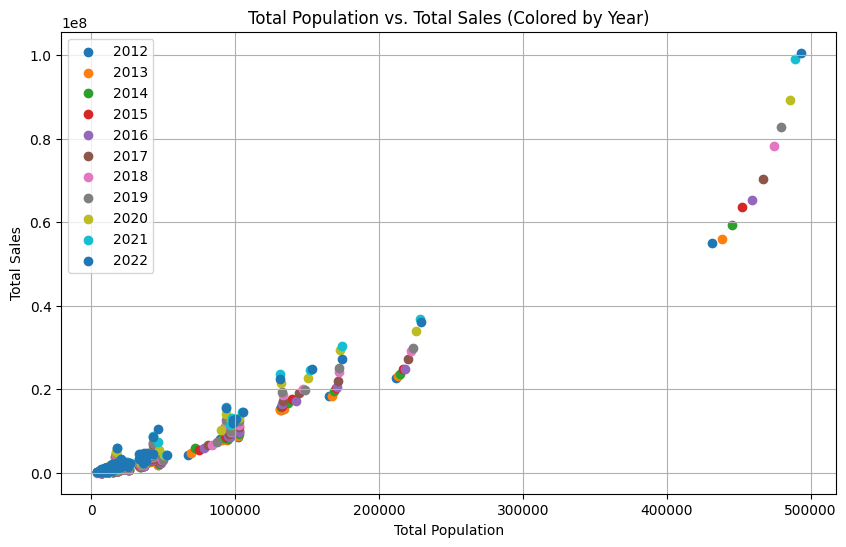

In [ ]:
plt.figure(figsize=(10, 6))
for year, data in df_year.groupby('year'):
  plt.scatter(data.index.get_level_values('total_pop'), data.values, label=str(year))

plt.xlabel('Total Population')
plt.ylabel('Total Sales')
plt.title('Total Population vs. Total Sales (Colored by Year)')
plt.grid(True)
plt.legend()
plt.show()


## Model Fitting

This code implements two types of regression models: a simple linear regression and ridge regression. The LinearRegression class calculates the best-fit line by using the normal equation, while RidgeRegression extends this by including regularization to prevent overfitting, controlled by the parameter alpha. The code also provides essential data preprocessing functions, including a min_max_scale() function to normalize the data and train_test_split() to divide the dataset into training and testing sets.

For model evaluation, the code defines metrics like RMSE and R-squared through regression_metrics() and includes a cross-validation function (cross_validation()) to assess model performance across multiple folds. Additionally, the rfe() (Recursive Feature Elimination) function performs feature selection by iteratively removing the least important features based on their coefficients. This comprehensive approach ensures robust model training, evaluation, and feature selection.

In [ ]:
class LinearRegression:
    def __init__(self):
        self.coef_ = None
        self.intercept_ = None

    def fit(self,X_train,y_train):
        X_train = np.insert(X_train, 0, 1,axis=1)
        result = np.linalg.inv(np.dot(X_train.T,X_train)).dot(X_train.T).dot(y_train)
        self.intercept_ = result[0]
        self.coef_ = result[1:]

    def predict(self,X_test):
        return np.dot(X_test,self.coef_) + self.intercept_

class RidgeRegression:
    def __init__(self, alpha=1.0):
        self.coef_ = None
        self.intercept_ = None
        self.alpha = alpha

    def fit(self, X_train, y_train):
        X_train = np.insert(X_train, 0, 1, axis=1)
        n_features = X_train.shape[1]
        I = np.eye(n_features)
        I[0, 0] = 0
        regularization_term = self.alpha * I
        result = np.linalg.inv(np.dot(X_train.T, X_train) + regularization_term).dot(X_train.T).dot(y_train)
        self.intercept_ = result[0]
        self.coef_ = result[1:]

    def predict(self, X_test):
        return np.dot(X_test, self.coef_) + self.intercept_

def min_max_scale(df, columns):
    df_new = df.copy()
    for column in columns:
        min_val = df[column].min()
        max_val = df[column].max()
        df_new[column] = (df[column] - min_val) / (max_val - min_val)
    return df_new

def train_test_split(X, y, test_size=0.2, random_state=None):
  if random_state is not None:
        np.random.seed(random_state)
  indices = np.arange(len(X))
  np.random.shuffle(indices)
  test_size = int(len(X) * test_size)
  test_indices = indices[:test_size]
  train_indices = indices[test_size:]
  return X.iloc[train_indices], X.iloc[test_indices], y.iloc[train_indices], y.iloc[test_indices]

def regression_metrics(y_true, y_pred):
    rss = np.sum((y_true - y_pred) ** 2)
    tss = np.sum((y_true - np.mean(y_true)) ** 2)
    rmse_value = np.sqrt(rss / len(y_true))
    r_squared_value = 1 - (rss / tss)
    return rmse_value, r_squared_value

def cross_validation(X, y, model, k=5, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    indices = np.arange(len(y))
    np.random.shuffle(indices)

    fold_size = len(y) // k
    folds = [indices[i * fold_size:(i + 1) * fold_size] for i in range(k)]

    r2_list = []

    for i in range(k):
        validation_indices = folds[i]
        train_indices = np.concatenate([folds[j] for j in range(k) if j != i])

        X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
        X_val, y_val = X.iloc[validation_indices], y.iloc[validation_indices]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        r2_list.append(regression_metrics(y_val, y_pred)[1])

    return np.mean(r2_list)

def cross_validation_rmse(X, y, model, k=5, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    indices = np.arange(len(y))
    np.random.shuffle(indices)

    fold_size = len(y) // k
    folds = [indices[i * fold_size:(i + 1) * fold_size] for i in range(k)]

    rmse_list = []

    for i in range(k):
        validation_indices = folds[i]
        train_indices = np.concatenate([folds[j] for j in range(k) if j != i])

        X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
        X_val, y_val = X.iloc[validation_indices], y.iloc[validation_indices]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        rmse_list.append(regression_metrics(y_val, y_pred)[0])

    return np.mean(rmse_list)

def rfe(X, y, n_features_to_select):
    selected_features = list(X.columns)
    selected_features.remove("one_race")
    feature_count = len(selected_features)

    while len(selected_features) > n_features_to_select:
        model = LinearRegression()
        model.fit(X[selected_features], y)

        coefficients = model.coef_
        abs_coefficients = np.abs(coefficients)

        least_important_feature_index = np.argmin(abs_coefficients)
        least_important_feature = selected_features[least_important_feature_index]
        selected_features.remove(least_important_feature)
    return selected_features

### DEAD


In these cells, a linear regression model is used to analyze the relationship between a set of demographic features (features_DARE) and the target variable, which is liquor sales per capita (sale_per_capita). The data is first standardized using a min_max_scale() function, and the model is trained on this scaled data. After fitting the model, the coefficients for each feature are extracted and displayed, sorted by their absolute values to indicate which features have the strongest influence on liquor sales per capita.

In the next set of cells, the data is split into training and testing sets using train_test_split(). A linear regression model is trained on the training set, and predictions are made on the test set. The model’s performance is evaluated using RMSE (Root Mean Squared Error) and R², which indicate a moderate fit. Additionally, cross-validation is performed to further assess the model’s generalizability, with an R² score output from multiple validation folds. These steps ensure a robust assessment of the model’s predictive power.

In [ ]:
X = final_df[features_DARE]
y = final_df['sale_per_capita']

In [ ]:
LinReg = LinearRegression()
X_standardized = min_max_scale(X, features_DARE)
LinReg.fit(X_standardized,y)
coefficient_dict = {feature: coef for feature, coef in zip(features_DARE, LinReg.coef_)}
coefficient_dict['intercept'] = LinReg.intercept_
sorted_coeffs = sorted(coefficient_dict.items(),
                                           key=lambda x: abs(x[1]),
                                           reverse=True)
print("{:<25} {:<15}".format("Feature", "Standardized Coefficient"))
print("-" * 50)
for feature, coef in sorted_coeffs:
    print("{:<25} {:<15.4f}".format(feature, coef))

Feature                   Standardized Coefficient
--------------------------------------------------
one_race                  5.2571         
two_plus_races            4.3871         
white                     -4.3068        
intercept                 -2.8407        
grouped_category_Whiskeys 1.6899         
asian                     -1.4773        
other_race                -1.4392        
grouped_category_Vodka    1.3408         
hisp_latino               1.2195         
white_non_hisp            1.2018         
am_indian_alaskan         -1.0719        
grouped_category_Rums     0.8683         
grouped_category_Liqueurs 0.7884         
bachelors                 0.7457         
black_afam                -0.7040        
grouped_category_Bourbon  0.4369         
adult_pop                 0.4023         
grouped_category_Tequila  0.3555         
grouped_category_Schnapps 0.2966         
grouped_category_Other    0.2551         
grouped_category_Brandies 0.2535         
median_income   

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
rmse_test, r2_test = regression_metrics(y_test, y_test_pred)
print("Test RMSE:", rmse_test)
print("Test R^2:", r2_test)

Test RMSE: 0.4233263044416185
Test R^2: 0.6047356449215187


In [ ]:
cross_validation(X, y, LinearRegression(), random_state = 1)

0.5977543362369033

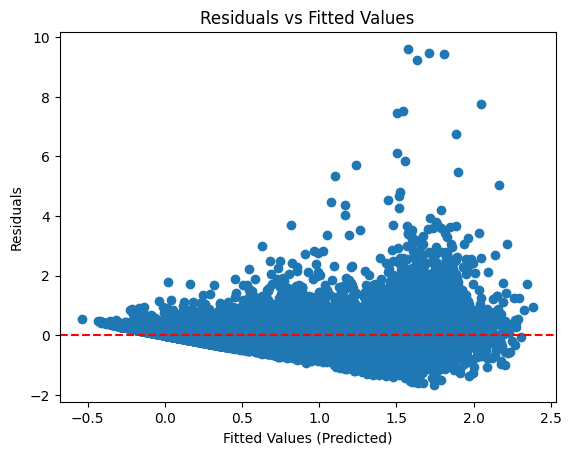

In [ ]:
# Compute residuals
residuals = y_test - y_test_pred

# Plot residuals vs fitted values
plt.scatter(y_test_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted Values (Predicted)')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

#### Feature Selection

In this cell, the Recursive Feature Elimination (RFE) method is used to iteratively find the best subset of features that maximizes the model’s performance. Starting with a set number of features (n), the function rfe() is applied to prune less important features from the dataset. For each subset of pruned features, the dataset is then passed through cross-validation to calculate the R² score, which measures the model's goodness-of-fit.

The loop iterates through different feature counts (from 34 to the total number of features), and for each iteration, the best performing subset is selected based on the highest R² value. The best subset of features and the corresponding R² score are saved and printed at the end, identifying the optimal set of predictors for the linear regression model. This approach helps in selecting the most impactful features while avoiding overfitting.

In [ ]:
best_r2 = 0
for n in range(34, len(X.columns) + 1):
  features = rfe(X_standardized, y, n)
  pruned_X = X[features]
  r2 = cross_validation(pruned_X, y, LinearRegression(), random_state = 1)
  if r2 > best_r2:
    best_r2 = r2
    best_features = features

print("Best R^2:", best_r2)
print("Best Features:", best_features)

Best R^2: 0.5992579022148032
Best Features: ['median_age', 'male', 'white', 'black_afam', 'am_indian_alaskan', 'asian', 'pacific_islander', 'other_race', 'two_plus_races', 'hisp_latino', 'white_non_hisp', 'div_sep', 'widowed', 'some_college_assoc', 'bachelors', 'median_income', 'below_poverty', 'poverty_100_149', 'adult_pop', 'month_name_August', 'month_name_December', 'month_name_February', 'month_name_January', 'month_name_July', 'month_name_June', 'month_name_March', 'month_name_May', 'month_name_November', 'month_name_October', 'month_name_September', 'grouped_category_Bourbon', 'grouped_category_Brandies', 'grouped_category_Cocktails', 'grouped_category_Gins', 'grouped_category_Liqueurs', 'grouped_category_Other', 'grouped_category_Rums', 'grouped_category_Schnapps', 'grouped_category_Scotch', 'grouped_category_Tequila', 'grouped_category_Vodka', 'grouped_category_Whiskeys']


In [ ]:
print(len(best_features))

42


In [ ]:
LinReg = LinearRegression()
LinReg.fit(X_standardized[best_features],y)
coefficient_dict = {feature: coef for feature, coef in zip(best_features, LinReg.coef_)}
sorted_coeffs = sorted(coefficient_dict.items(),
                                           key=lambda x: abs(x[1]),
                                           reverse=True)
print("{:<25} {:<15}".format("Feature", "Standardized Coefficient"))
print("-" * 50)
for feature, coef in sorted_coeffs:
    print("{:<25} {:<15.4f}".format(feature, coef))
print("{:<25} {:<15.4f}".format("intercept", LinReg.intercept_))

Feature                   Standardized Coefficient
--------------------------------------------------
white                     -4.3148        
grouped_category_Whiskeys 1.6900         
asian                     -1.4806        
other_race                -1.4412        
grouped_category_Vodka    1.3408         
hisp_latino               1.2103         
white_non_hisp            1.1859         
am_indian_alaskan         -1.0768        
two_plus_races            -0.9940        
grouped_category_Rums     0.8683         
grouped_category_Liqueurs 0.7884         
bachelors                 0.7665         
black_afam                -0.7094        
grouped_category_Bourbon  0.4369         
adult_pop                 0.4050         
grouped_category_Tequila  0.3555         
grouped_category_Schnapps 0.2966         
grouped_category_Other    0.2551         
grouped_category_Brandies 0.2535         
male                      -0.2192        
median_income             0.2097         
div_sep         

#### Best Features - For Interpretations

In these cells, the coefficients from a linear regression model are analyzed to identify the most influential features in predicting liquor sales per capita. The coefficients are divided into categories—positive and negative—based on their values, representing the direction and strength of each feature’s impact.

The first set of cells sorts and displays the top five most positive and negative coefficients, with features like grouped_category_Whiskeys and hisp_latino having the strongest positive effects, while white and asian have strong negative effects. The second set further filters the coefficients to exclude months and categories, identifying demographic features like hisp_latino, white_non_hisp, and bachelors as having the highest influence.

The final set of cells breaks down the analysis into three specific groups: months, liquor categories, and demographics. It ranks the top positive and negative coefficients for each group, revealing that certain months (like December and October) and liquor categories (like Vodka and Whiskeys) have the strongest effects on liquor sales per capita. This analysis helps in interpreting how different time periods, categories, and population segments influence sales trends.

In [ ]:
top_positive_coeffs = sorted(coefficient_dict.items(), key=lambda item: item[1], reverse=True)[:5]
top_negative_coeffs = sorted(coefficient_dict.items(), key=lambda item: item[1])[:5]

print("Top 5 Most Positive Coefficients:")
for feature, coef in top_positive_coeffs:
    print(f"{feature}: {coef}")

print("\nTop 5 Most Negative Coefficients:")
for feature, coef in top_negative_coeffs:
    print(f"{feature}: {coef}")

Top 5 Most Positive Coefficients:
grouped_category_Whiskeys: 1.6899522852107676
grouped_category_Vodka: 1.3407970532120141
hisp_latino: 1.2102976965898555
white_non_hisp: 1.1859043550607193
grouped_category_Rums: 0.8682722582367639

Top 5 Most Negative Coefficients:
white: -4.314796830903262
asian: -1.4805751059101095
other_race: -1.4411785000032566
am_indian_alaskan: -1.0768285487456195
two_plus_races: -0.9940208346403296


In [ ]:
filtered_coeffs = {k: v for k, v in coefficient_dict.items() if not k.startswith('month_name_') and not k.startswith('grouped_category_')}

top_positive_coeffs = [(feature, coef) for feature, coef in filtered_coeffs.items() if coef > 0]
top_positive_coeffs = sorted(top_positive_coeffs, key=lambda item: item[1], reverse=True)[:10]

top_negative_coeffs = [(feature, coef) for feature, coef in filtered_coeffs.items() if coef < 0]
top_negative_coeffs = sorted(top_negative_coeffs, key=lambda item: item[1])[:10]

print("Most Positive Coefficients in predicting\nsales per capita (excluding months and categories):")
for feature, coef in top_positive_coeffs:
    print(f"{feature}: {coef}")

print("\nMost Negative Coefficients in predicting\nsales per capita (excluding months and categories):")
for feature, coef in top_negative_coeffs:
    print(f"{feature}: {coef}")

Most Positive Coefficients in predicting
sales per capita (excluding months and categories):
hisp_latino: 1.2102976965898555
white_non_hisp: 1.1859043550607193
bachelors: 0.7665315924830771
adult_pop: 0.4050472226992511
median_income: 0.20973373953895597
div_sep: 0.2020559266325719
some_college_assoc: 0.11863770132965994
poverty_100_149: 0.04504458945935906
median_age: 0.04299291680527391
pacific_islander: 0.0406567824621546

Most Negative Coefficients in predicting
sales per capita (excluding months and categories):
white: -4.314796830903262
asian: -1.4805751059101095
other_race: -1.4411785000032566
am_indian_alaskan: -1.0768285487456195
two_plus_races: -0.9940208346403296
black_afam: -0.7094125121410413
male: -0.21922838631180366
below_poverty: -0.05737646339078103


In [ ]:
top_positive_month_coeffs = [
    (feature, coef)
    for feature, coef in coefficient_dict.items()
    if feature.startswith("month_name_") and coef > 0
]
top_positive_month_coeffs.sort(key=lambda x: x[1], reverse=True)

top_negative_month_coeffs = [
    (feature, coef)
    for feature, coef in coefficient_dict.items()
    if feature.startswith("month_name_") and coef < 0
]
top_negative_month_coeffs.sort(key=lambda x: x[1])


top_positive_category_coeffs = [
    (feature, coef)
    for feature, coef in coefficient_dict.items()
    if feature.startswith("grouped_category_") and coef > 0
]
top_positive_category_coeffs.sort(key=lambda x: x[1], reverse=True)

top_negative_category_coeffs = [
    (feature, coef)
    for feature, coef in coefficient_dict.items()
    if feature.startswith("grouped_category_") and coef < 0
]
top_negative_category_coeffs.sort(key=lambda x: x[1])

print("Top Positive Month Coefficients in predicting\nsales per capita:")
for feature, coef in top_positive_month_coeffs:
    print(f"{feature}: {coef}")

print("\nTop Negative Month Coefficients in predicting\nsales per capita:")
for feature, coef in top_negative_month_coeffs:
    print(f"{feature}: {coef}")

print("\nTop Category Coefficients in predicting\nsales per capita:")
for feature, coef in top_positive_category_coeffs:
    print(f"{feature}: {coef}")

print("\nTop Negative Category Coefficients in predicting\nsales per capita:")
for feature, coef in top_negative_category_coeffs:
    print(f"{feature}: {coef}")


Top Positive Month Coefficients in predicting
sales per capita:
month_name_December: 0.15704741232895073
month_name_October: 0.10319478588234318
month_name_June: 0.07117500743784812
month_name_May: 0.06101361008763084
month_name_August: 0.04642304431948189
month_name_July: 0.04582971973283962
month_name_November: 0.030957614608400304
month_name_September: 0.02215938398647072

Top Negative Month Coefficients in predicting
sales per capita:
month_name_January: -0.05962861587102495
month_name_February: -0.045008094051032385
month_name_March: -0.016584354226821245

Top Category Coefficients in predicting
sales per capita:
grouped_category_Whiskeys: 1.6899522852107676
grouped_category_Vodka: 1.3407970532120141
grouped_category_Rums: 0.8682722582367639
grouped_category_Liqueurs: 0.7883734806985689
grouped_category_Bourbon: 0.43690126836996723
grouped_category_Tequila: 0.3555239377596432
grouped_category_Schnapps: 0.2965676603830196
grouped_category_Other: 0.25511653059691064
grouped_category

### Booze R US

In these cells, linear regression and ridge regression are used to analyze the relationship between features from the dataset and liquor sales per capita. The first attempt with linear regression results in a "Singular Matrix" error, indicating that the matrix used in the calculations is not invertible, due to perfect multicollinearity.

To overcome this, ridge regression is applied with various values of the regularization parameter (alpha). Ridge regression adds a regularization term to address issues like multicollinearity, making the matrix invertible. The model is evaluated using cross-validation, and the best alpha value is selected based on the R² score. In this case, the best alpha is found to be 1.0, with a corresponding R² value of 0.711, indicating a strong model performance. This demonstrates how ridge regression helps stabilize the model when linear regression fails due to data issues.

In [ ]:
X = final_df_with_interactions[features_BOOZE]
y = final_df_with_interactions['sale_per_capita']
print("Linear Regression:")
print(cross_validation(X, y, LinearRegression(), random_state = 1))

Linear Regression:


LinAlgError: Singular matrix

In [ ]:
X = final_df_with_interactions[features_BOOZE]
y = final_df_with_interactions['sale_per_capita']
alpha_values = np.arange(0.5, 3, 0.5).tolist()
best_alpha = None
best_r2 = -np.inf
for alpha in alpha_values:
  model = RidgeRegression(alpha=alpha)
  r2 = cross_validation(X, y, model, random_state = 1)
  if r2 > best_r2:
    best_r2 = r2
    best_alpha = alpha
print("Ridge Regression:")
print("Best Alpha:", best_alpha)
print("Best R^2:", best_r2)

Increased the cross-validated R^2 from 0.5991433582536697 (simple, interpretable model for dare) to 0.7118597677666095 by including interactions and doing a ridge regression to account for the high multicollinearity.

Can use this model to predict what a counties total sales will look like in 2025 for each month and alcohol category, only need demographics data.

In [ ]:
X = final_df_with_interactions[features_BOOZE]
y = final_df_with_interactions['sale_per_capita']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RidgeRegression(alpha = 1)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
rmse_test, r2_test = regression_metrics(y_test, y_test_pred)
print("Test RMSE:", rmse_test)
print("Test R^2:", r2_test)

**DARE MODEL:**

Test RMSE: 0.4233263044416185

Test R^2: 0.6047356449215187

**BOOZE R US MODEL:**

Test RMSE: 0.36127390289677863

Test R^2: 0.7121207764989228

In [ ]:
X = final_df_with_interactions[features_BOOZE]
y = final_df_with_interactions['sale_per_capita']
model = RidgeRegression(alpha = 1)
model.fit(X, y)

In [ ]:
coefficient_dict = {feature: coef for feature, coef in zip(features_BOOZE, model.coef_)}
sorted_coeffs = sorted(coefficient_dict.items(),
                                           key=lambda x: abs(x[1]),
                                           reverse=True)
print("{:<25} {:<15}".format("Feature", "Coefficient"))
print("-" * 50)
for feature, coef in sorted_coeffs:
    print("{:<25} {:<15.4f}".format(feature, coef))

#### Predictions

In [ ]:
# Example usage
data = {
    'county': ['MadeUpCounty'],
    'year': [2024],
    'total_pop': [demographics['total_pop'].mean()],
    'median_age': [demographics['median_age'].mean()],
    'male': [demographics['male'].mean()],
    'one_race': [demographics['one_race'].mean()],
    'white': [demographics['white'].mean()],
    'black_afam': [demographics['black_afam'].mean()],
    'am_indian_alaskan': [demographics['am_indian_alaskan'].mean()],
    'asian': [demographics['asian'].mean()],
    'pacific_islander': [demographics['pacific_islander'].mean()],
    'other_race': [demographics['other_race'].mean()],
    'two_plus_races': [demographics['two_plus_races'].mean()],
    'hisp_latino': [demographics['hisp_latino'].mean()],
    'white_non_hisp': [demographics['white_non_hisp'].mean()],
    'div_sep': [demographics['div_sep'].mean()],
    'widowed': [demographics['widowed'].mean()],
    'less_hs': [demographics['less_hs'].mean()],
    'hs_grad': [demographics['hs_grad'].mean()],
    'some_college_assoc': [demographics['some_college_assoc'].mean()],
    'bachelors': [demographics['bachelors'].mean()],
    'median_income': [demographics['median_income'].mean()],
    'below_poverty': [demographics['below_poverty'].mean()],
    'poverty_100_149': [demographics['poverty_100_149'].mean()],
    'adult_pop': [demographics['adult_pop'].mean()],
    'month_name_August': [0],
    'month_name_December': [1],
    'month_name_February': [0],
    'month_name_January': [0],
    'month_name_July': [0],
    'month_name_June': [0],
    'month_name_March': [0],
    'month_name_May': [0],
    'month_name_November': [0],
    'month_name_October': [0],
    'month_name_September': [0],
    'grouped_category_Bourbon':[0],
    'grouped_category_Brandies':[0],
    'grouped_category_Cocktails':[0],
    'grouped_category_Gins':[0],
    'grouped_category_Liqueurs':[0],
    'grouped_category_Other':[0],
    'grouped_category_Rums':[0],
    'grouped_category_Schnapps':[0],
    'grouped_category_Scotch':[0],
    'grouped_category_Tequila':[0],
    'grouped_category_Vodka':[1],
    'grouped_category_Whiskeys':[0]
}
df_madeup_county = pd.DataFrame(data)
df_madeup_county[['total_pop', 'median_age', 'male', 'one_race', 'white', 'black_afam',
            'am_indian_alaskan', 'asian', 'pacific_islander', 'other_race',
            'two_plus_races', 'hisp_latino', 'white_non_hisp', 'div_sep', 'widowed',
            'less_hs', 'hs_grad', 'some_college_assoc', 'bachelors', 'median_income',
            'below_poverty', 'poverty_100_149', 'adult_pop']]

,total_pop,median_age,male,one_race,white,black_afam,am_indian_alaskan,asian,pacific_islander,other_race,...,div_sep,widowed,less_hs,hs_grad,some_college_assoc,bachelors,median_income,below_poverty,poverty_100_149,adult_pop
0,31493.550046,41.861157,0.498837,0.981484,0.942705,0.013539,0.00334,0.010372,0.0007,0.010789,...,0.116368,0.074135,0.087711,0.363702,0.336037,0.15055,29340.778696,0.113502,0.090951,0.769223


Example usage: Predict sales for a made up county for December 2024 using average demographics data for Iowa.

In [ ]:
df_madeup_county_interactions = create_interaction_features(df_madeup_county, features)
X_madeup_county = df_madeup_county_interactions[features_BOOZE]

y_pred_madeup_county_1 = model.predict(X_madeup_county) * df_madeup_county_interactions['total_pop']
formatted_sales = "${:,.2f}".format(y_pred_madeup_county_1[0])
print("Predicted Total Sales for vodka in December 2024 in made up county in dollars:", formatted_sales)

Predicted Total Sales for vodka in December 2024 in made up county in dollars: $45,970.57


In [ ]:
df_madeup_county['median_income'] = df_madeup_county['median_income'] - 20000
df_madeup_county_interactions = create_interaction_features(df_madeup_county, features)
X_madeup_county = df_madeup_county_interactions[features_BOOZE]

y_pred_madeup_county_2 = model.predict(X_madeup_county) * df_madeup_county_interactions['total_pop']
formatted_sales = "${:,.2f}".format(y_pred_madeup_county_2[0])
print("Predicted Total Sales for vodka in December 2024 in made up county with lower median income of 20,000 in dollars:", formatted_sales)

Predicted Total Sales for vodka in December 2024 in made up county with lower median income of 20,000 in dollars: $30,450.29


In [ ]:
df_madeup_county['grouped_category_Vodka'] = [0]
df_madeup_county['grouped_category_Whiskeys'] = [1]
df_madeup_county_interactions = create_interaction_features(df_madeup_county, features)
X_madeup_county = df_madeup_county_interactions[features_BOOZE]

y_pred_madeup_county_3 = model.predict(X_madeup_county) * df_madeup_county_interactions['total_pop']
formatted_sales = "${:,.2f}".format(y_pred_madeup_county_3[0])
print("Predicted Total Sales for Whiskey in December 2024 in made up county with lower median income of 20,000 in dollars:", formatted_sales)

Predicted Total Sales for Whiskey in December 2024 in made up county with lower median income of 20,000 in dollars: $57,159.99


In [ ]:
df_madeup_county['median_income'] = df_madeup_county['median_income'] + 20000
df_madeup_county_interactions = create_interaction_features(df_madeup_county, features)
X_madeup_county = df_madeup_county_interactions[features_BOOZE]
y_pred_madeup_county_4 = model.predict(X_madeup_county) * df_madeup_county_interactions['total_pop']
formatted_sales = "${:,.2f}".format(y_pred_madeup_county_4[0])
print("Predicted Total Sales for Whiskey in December 2024 in made up county with avg income:", formatted_sales)

Predicted Total Sales for Whiskey in December 2024 in made up county with avg income: $73,291.54


             Scenario  Predicted Sales
   Vodka, Avg. Income     45970.568217
  Vodka, Lower Income     30450.293068
 Whiskey, Avg. Income     73291.537434
Whiskey, Lower Income     57159.994712


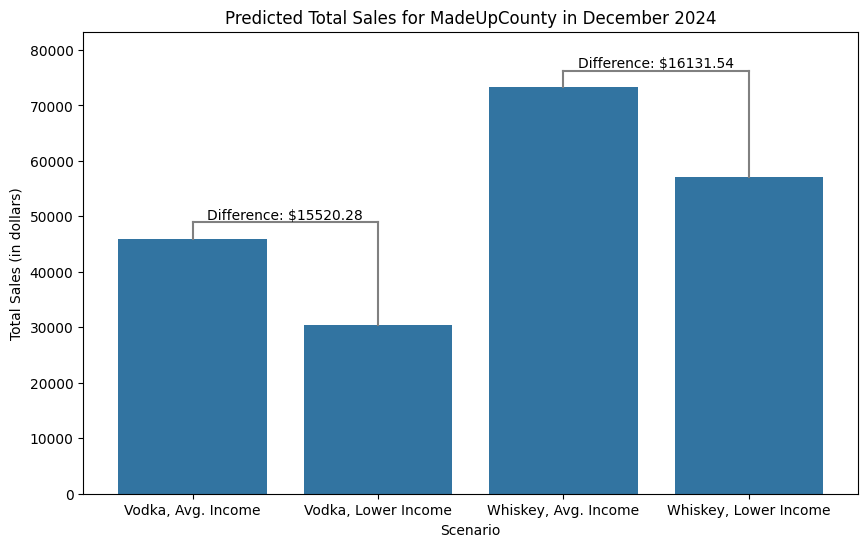

In [ ]:
predicted_sales_data = {
    'Scenario': ['Vodka, Avg. Income', 'Vodka, Lower Income', 'Whiskey, Avg. Income', 'Whiskey, Lower Income'],
    'Predicted Sales': [
        y_pred_madeup_county_1[0] if len(y_pred_madeup_county_1) > 0 else 0,
        y_pred_madeup_county_2[0] if len(y_pred_madeup_county_2) > 0 else 0,
        y_pred_madeup_county_4[0] if len(y_pred_madeup_county_4) > 0 else 0,
        y_pred_madeup_county_3[0] if len(y_pred_madeup_county_3) > 0 else 0,
    ]
}
predicted_sales_df = pd.DataFrame(predicted_sales_data)

print(predicted_sales_df.to_string(index=False))

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Scenario', y='Predicted Sales', data=predicted_sales_df)
plt.title('Predicted Total Sales for MadeUpCounty in December 2024')
plt.ylabel('Total Sales (in dollars)')

plt.ylim(0, predicted_sales_df['Predicted Sales'].max() + 10000)

for i in range(0, len(predicted_sales_df), 2):
    bar1 = predicted_sales_df['Predicted Sales'][i]
    bar2 = predicted_sales_df['Predicted Sales'][i+1]
    difference = bar1 - bar2

    x_coord_1 = ax.patches[i].get_x() + ax.patches[i].get_width() / 2
    x_coord_2 = ax.patches[i+1].get_x() + ax.patches[i+1].get_width() / 2
    x_mid = (x_coord_1 + x_coord_2) / 2

    y_max = max(bar1, bar2)
    ax.plot([x_coord_1, x_coord_1], [bar1, y_max + 3000], color='gray', linewidth=1.5)
    ax.plot([x_coord_2, x_coord_2], [bar2, y_max + 3000], color='gray', linewidth=1.5)
    ax.plot([x_coord_1, x_coord_2], [y_max + 3000, y_max + 3000], color='gray', linewidth=1.5)

    ax.text(x_mid, y_max + 3500, f"Difference: ${difference:.2f}", ha="center", fontsize=10)

plt.show()


#### Extra Stuff

In [ ]:
plt.figure(figsize=(10, 6))
y_pred = model.predict(X)
plt.scatter(y_pred, y_pred - y)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Fitted vs. Residuals Plot For Model 2")
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [ ]:
X = final_df_with_interactions[features_BOOZE]
y = np.log(final_df_with_interactions['sale_per_capita'])
nan_indices = y[y.isna()].index
inf_indices = y[np.isinf(y)].index
invalid_indices = nan_indices.union(inf_indices)

In [ ]:
final_df_with_interactions['sale_per_capita'].iloc[invalid_indices]

In [ ]:
X = X.drop(invalid_indices)
y = y.drop(invalid_indices)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RidgeRegression(alpha = 1)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
rmse_test, r2_test = regression_metrics(y_test, y_test_pred)
print("Test RMSE:", rmse_test)
print("Test R^2:", r2_test)

In [ ]:
cross_validation(X, y, RidgeRegression(alpha = 1), random_state = 1)

In [ ]:
model.fit(X, y)
plt.figure(figsize=(10, 6))
y_pred = model.predict(X)
plt.scatter(y_pred, y_pred - y)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Fitted vs. Residuals Plot For Model 3")
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [ ]:
cross_validation_rmse(X, y, RidgeRegression(alpha = 1), random_state = 1)

In [ ]:
X = final_df_with_interactions[features_BOOZE]
y = final_df_with_interactions['sale_per_capita']
cross_validation_rmse(X, y, RidgeRegression(alpha = 1), random_state = 1)

Model 1 (not transformed) has a smaller R^2 but also lower RMSE while Model 2 (transformed) has a higher R^2 but a higher RMSE, we will advise Model 1 since focused on minimizing prediction error.